# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
%matplotlib inline

import datetime
import glob
from collections import deque

import gym
import numpy as np
import tqdm
import torch
from matplotlib import pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from unityagents import UnityEnvironment

from sac.sac import SAC
from sac.replay_memory import ReplayMemory

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
# env = UnityEnvironment(file_name="Tennis_Linux/Tennis.x86_64")

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# # get the default brain
# brain_name = env.brain_names[0]
# brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# # reset the environment
# env_info = env.reset(train_mode=True)[brain_name]

# # number of agents 
# num_agents = len(env_info.agents)
# print('Number of agents:', num_agents)

# # size of each action
# action_size = brain.vector_action_space_size
# print('Size of each action:', action_size)

# # examine the state space 
# states = env_info.vector_observations
# state_size = states.shape[1]
# print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
# print('The state for the first agent looks like:', states[0])

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
# for i in range(1, 6):                                      # play game for 5 episodes
#     env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
#     states = env_info.vector_observations                  # get the current state (for each agent)
#     scores = np.zeros(num_agents)                          # initialize the score (for each agent)
#     while True:
#         actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
#         actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
#         env_info = env.step(actions)[brain_name]           # send all actions to tne environment
#         next_states = env_info.vector_observations         # get next state (for each agent)
#         rewards = env_info.rewards                         # get reward (for each agent)
#         dones = env_info.local_done                        # see if episode finished
#         scores += env_info.rewards                         # update the score (for each agent)
#         states = next_states                               # roll over states to next time step
#         if np.any(dones):                                  # exit loop if episode finished
#             break
#     print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

When finished, you can close the environment.

In [6]:
# env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [2]:
##### MODIFY-ME #####
tennis_binary_path = "Tennis_Linux/Tennis.x86_64"

# Settings
replay_size = 50000
num_episodes = 5000
num_init_random_steps = 1000
batch_size = 256
updates_per_step = 1
hidden_size = [64, 64]
adam_learning_rate = 2e-4
gamma = 0.95
tau = 0.005
initial_entropy = 1.0
automatic_entropy_tuning = True
target_update_interval = 1

eval_num_episodes = 3

In [3]:
# Initialize environment
env = UnityEnvironment(file_name=tennis_binary_path)
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
state = env.reset(train_mode=True)[brain_name]
observation_size = state.vector_observations.shape[1]
action_space = gym.spaces.Box(low=-1, high=1, shape=[brain.vector_action_space_size], dtype=np.float32)
num_agents = state.vector_observations.shape[0]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [4]:
# Initialize agent, replay buffer, and tensorboard logger
agent = SAC(
    num_inputs=observation_size,
    action_space=action_space,
    hidden_size=hidden_size,
    lr=adam_learning_rate,
    gamma=gamma,
    tau=tau,
    alpha=initial_entropy,
    target_update_interval=target_update_interval,
    automatic_entropy_tuning=automatic_entropy_tuning
)
memory = ReplayMemory(int(replay_size))
datetime_str = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
writer = SummaryWriter(f"runs/SAC_{datetime_str}")

# Training Loop
total_num_updates = 0
total_num_steps = 0
latest_scores = deque(maxlen=100)
all_raw_scores = []
all_avg_scores = []
pbar = tqdm.tqdm_notebook(range(num_episodes), desc="Ep")
for episode_idx in pbar:
    episode_num_steps = 0
    sum_rewards = np.zeros((num_agents,))

    states = env.reset(train_mode=True)[brain_name].vector_observations
    while True:
        # Sample action and step env
        actions = np.zeros((num_agents, action_space.shape[0]))
        for agent_idx in range(num_agents):
            if total_num_steps < num_init_random_steps:
                actions[agent_idx] = action_space.sample()
            else:
                actions[agent_idx] = agent.select_action(states[agent_idx])

        env_info = env.step(actions)[brain_name]
        next_states, rewards, dones = env_info.vector_observations, env_info.rewards, env_info.local_done

        # Save experience into replay buffer
        for agent_idx in range(num_agents):
            memory.push(states[agent_idx], actions[agent_idx], rewards[agent_idx], next_states[agent_idx], float(not dones[agent_idx]))

        # Train agent
        if len(memory) > batch_size:
            for _ in range(updates_per_step * num_agents):
                critic_1_loss, critic_2_loss, policy_loss, ent_loss, alpha = agent.update_parameters(memory, batch_size, total_num_updates)
                total_num_updates += 1

        # Update state and stats
        states = next_states
        episode_num_steps += 1
        total_num_steps += 1
        sum_rewards += rewards

        if np.any(dones):
            break

    # Update stats
    score = np.max(sum_rewards)
    latest_scores.append(score)
    all_raw_scores.append(score)
    avg_score = np.mean(latest_scores)
    all_avg_scores.append(avg_score)
    pbar.set_postfix(NbStep=episode_num_steps, TotUpd=total_num_updates, AvgG=avg_score, G=score)

    writer.add_scalar("episode/curr_num_steps", episode_num_steps, episode_idx)
    writer.add_scalar("episode/total_num_steps", total_num_steps, episode_idx)
    writer.add_scalar("episode/total_num_updates", total_num_updates, episode_idx)
    writer.add_scalar("episode/raw_score", score, episode_idx)
    writer.add_scalar("episode/avg_score", avg_score, episode_idx)
    if total_num_updates > 0:
        writer.add_scalar("update/critic_1_loss", critic_1_loss, total_num_updates)
        writer.add_scalar("update/critic_2_loss", critic_2_loss, total_num_updates)
        writer.add_scalar("update/policy_loss", policy_loss, total_num_updates)
        writer.add_scalar("update/ent_loss", ent_loss, total_num_updates)
        writer.add_scalar("update/alpha", alpha, total_num_updates)
    writer.flush()

    if avg_score >= 0.5:
        print(f"Saving checkpoint on episode {episode_idx+1} with avg score: {avg_score}")
        agent.save_model(f"tennis_{datetime_str}")

/home/mimic/.local/lib/python3.6/site-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Ep:   0%|          | 0/5000 [00:00<?, ?it/s]

nd models/sac_critic_tennis_2021-01-04_16-08-54.pt
Saving checkpoint on episode 2513 with avg score: 1.018000015206635
Saving models to models/sac_actor_tennis_2021-01-04_16-08-54.pt and models/sac_critic_tennis_2021-01-04_16-08-54.pt
Saving checkpoint on episode 2514 with avg score: 1.0420000155642628
Saving models to models/sac_actor_tennis_2021-01-04_16-08-54.pt and models/sac_critic_tennis_2021-01-04_16-08-54.pt
Saving checkpoint on episode 2515 with avg score: 1.0670000159367918
Saving models to models/sac_actor_tennis_2021-01-04_16-08-54.pt and models/sac_critic_tennis_2021-01-04_16-08-54.pt
Saving checkpoint on episode 2516 with avg score: 1.0650000159069897
Saving models to models/sac_actor_tennis_2021-01-04_16-08-54.pt and models/sac_critic_tennis_2021-01-04_16-08-54.pt
Saving checkpoint on episode 2517 with avg score: 1.0890000162646174
Saving models to models/sac_actor_tennis_2021-01-04_16-08-54.pt and models/sac_critic_tennis_2021-01-04_16-08-54.pt
Saving checkpoint on epis

KeyboardInterrupt: 

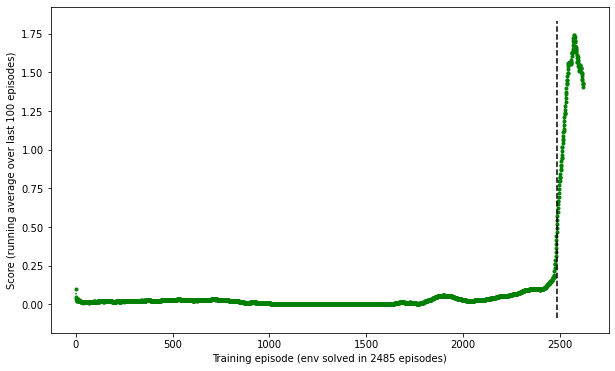

In [6]:
# Compute statistics
scores = all_avg_scores
num_episodes_to_solve_env = -1
solved_ep_idxes = np.where(np.array(scores) >= 0.5)
if len(solved_ep_idxes) > 0:
    num_episodes_to_solve_env = solved_ep_idxes[0][0] + 1  # +1 since ep_idx is 0-indexed

# Plot performance
plt.figure(figsize=(10,6), facecolor="white")
episodes = np.array(range(1, len(scores)+1))
plt.plot(episodes, scores, "g.:")
y_range = plt.ylim()
plt.plot((num_episodes_to_solve_env, num_episodes_to_solve_env), y_range, "k--")
plt.xlabel(f"Training episode (env solved in {num_episodes_to_solve_env} episodes)")
plt.ylabel("Score (running average over last 100 episodes)")
plt.savefig("training_curve.png")

In [4]:
# Evaluate saved agent

# Look for presence of model checkpoints
actor_path = glob.glob("models/sac_actor_*.pt")[0]
critic_path = actor_path.replace("sac_actor_", "sac_critic_")

# Initialize agent and load model
agent = SAC(
    num_inputs=observation_size,
    action_space=action_space,
    hidden_size=hidden_size,
    lr=adam_learning_rate,
    gamma=gamma,
    tau=tau,
    alpha=initial_entropy,
    target_update_interval=target_update_interval,
    automatic_entropy_tuning=automatic_entropy_tuning
)
agent.load_model(actor_path, critic_path)

ep_pbar = tqdm.tqdm_notebook(range(eval_num_episodes), desc="Eval")
for ep_idx in ep_pbar:
    # Initialize variables
    sum_rewards = np.zeros((num_agents,))
    num_steps = 0
    sum_reward = 0

    # Reset environment
    states = env.reset(train_mode=True)[brain_name].vector_observations

    # Step loop
    while True:
        actions = np.zeros((num_agents, action_space.shape[0]))
        for agent_idx in range(num_agents):
            actions[agent_idx] = agent.select_action(states[agent_idx], evaluate=True)

        env_info = env.step(actions)[brain_name]
        states, rewards, dones = env_info.vector_observations, env_info.rewards, env_info.local_done

        # Update state and stats
        sum_rewards += rewards
        num_steps += 1

        if np.any(dones):
            break
    
    score = np.max(sum_rewards)
    ep_pbar.set_postfix(nStep=num_steps, score=score)
    print(f"Evaluated episode {ep_idx+1} / {eval_num_episodes}: score={score}, num_steps={num_steps}")


Loading models from models/sac_actor_tennis_2021-01-04_16-08-54.pt and models/sac_critic_tennis_2021-01-04_16-08-54.pt
/home/mimic/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Eval:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluated episode 1 / 3: score=0.7000000104308128, num_steps=280
Evaluated episode 2 / 3: score=0.6000000089406967, num_steps=221
Evaluated episode 3 / 3: score=0.4000000059604645, num_steps=166


In [5]:
# Close environment
env.close()